In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Wed Feb 12 08:36:15 PST 2020


# Total Count, Stratified Count Hist and EPL as a function of Privacy Loss Budget

In [2]:
import dp_2020_census.data, dp_2020_census.model

In [3]:
df_orig = dp_2020_census.data.load_orig_counts()

In [4]:
def my_load(epsilon, stratification_cols):

    error = []

    for run in '1234':
        df_new = dp_2020_census.data.load_dp_counts(epsilon, run)
        error_run = dp_2020_census.model.perturbation_error(df_orig, df_new, stratification_cols)
        error += list(error_run)

    error = pd.Series(error)
    return dp_2020_census.model.empirical_privacy_loss(
                                        error, bandwidth=.1,
                                        est_range_percentile=95, est_range_multiplier=1.0)

In [5]:
%%time
def my_load_set(stratification_cols, epsilon_list):
    df_epl = {}
    for eps in epsilon_list:
        df_epl[eps] = my_load(eps, stratification_cols)
    return df_epl

df_epl = my_load_set(stratification_cols = ['state', 'county', 'enum_dist', 'age', 'race', 'eth'],
    epsilon_list = ['0.25', '0.50', '1.0', '2.0', '4.0', '8.0'])

/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:85: RuntimeWarning: divide by zero encountered in log
  df['epl_cusum'] = np.log(ccusum[1:] / ccusum[:-1])


CPU times: user 2min 11s, sys: 4.17 s, total: 2min 16s
Wall time: 2min 15s


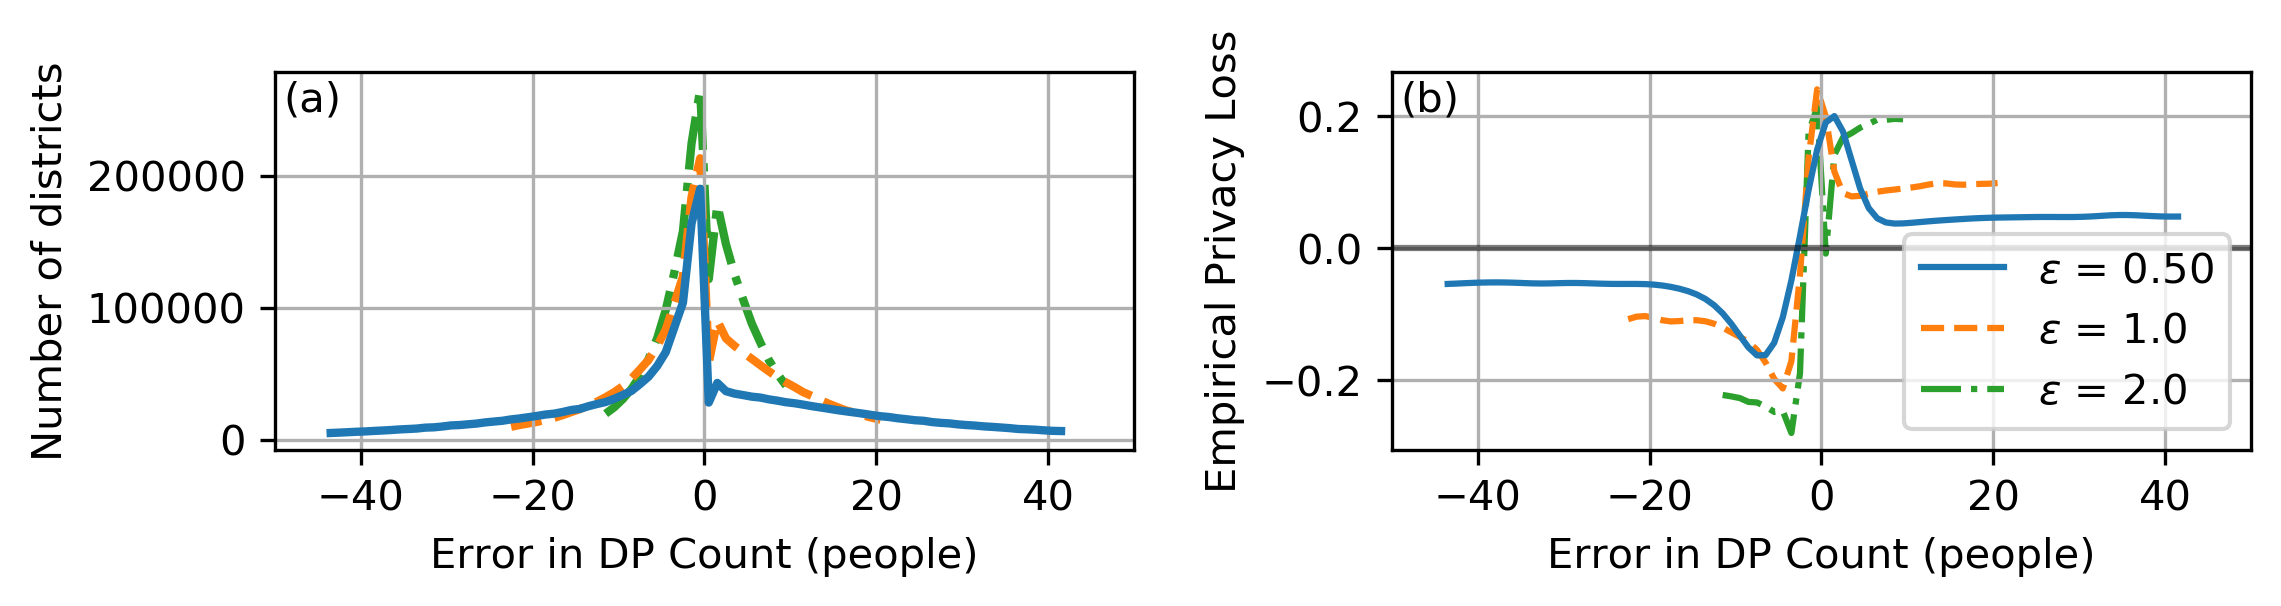

In [6]:
def my_plot(df_epl):
    fig, ax = plt.subplots(ncols=2, figsize=(8.5, 2), dpi=300)
    
    styles = ['-', '--', '-.']
    for i, eps in enumerate(['0.50', '1.0', '2.0']):
        style = styles[i]
        ax[0].plot(df_epl[eps]['hist'], linewidth=2, linestyle=style, zorder=1+1/(i+1))
        ax[1].plot(df_epl[eps]['smooth_epl'], label=f'$\epsilon$ = {eps}', linestyle=style, zorder=1+1/(i+1))

    ax[0].set_ylabel('Number of districts')
    ax[0].set_xlabel('Error in DP Count (people)')
    ax[0].set_xlim(-50, 50)
    ax[0].grid()
    ax[0].text(.01, .98, '(a)', transform=ax[0].transAxes, ha='left', va='top')

    ax[1].set_ylabel('Empirical Privacy Loss')
    ax[1].set_xlabel('Error in DP Count (people)')
    ax[1].axhline(0, color='k', alpha=.5)
    ax[1].set_xlim(-50, 50)
    ax[1].grid()
    ax[1].text(.01, .98, '(b)', transform=ax[1].transAxes, ha='left', va='top')
    ax[1].legend(loc='lower right')
    
    plt.subplots_adjust(wspace=.3, bottom=.25)

my_plot(df_epl)
plt.savefig('fig_1_hist_epl.png')